# Unsupervised classification with ISO clustering algorithm

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-a-Raster-object" data-toc-modified-id="Make-a-Raster-object-1">Make a <code>Raster</code> object</a></span></li><li><span><a href="#Train-ISO-classifier" data-toc-modified-id="Train-ISO-classifier-2">Train ISO classifier</a></span><ul class="toc-item"><li><span><a href="#Write-to-disk-for-future" data-toc-modified-id="Write-to-disk-for-future-2.1">Write to disk for future</a></span></li><li><span><a href="#Analyze-training-metrics" data-toc-modified-id="Analyze-training-metrics-2.2">Analyze training metrics</a></span></li></ul></li><li><span><a href="#Classify-raster" data-toc-modified-id="Classify-raster-3">Classify raster</a></span><ul class="toc-item"><li><span><a href="#Visualize-classification-result" data-toc-modified-id="Visualize-classification-result-3.1">Visualize classification result</a></span></li></ul></li><li><span><a href="#Post-process-classified-output-layer" data-toc-modified-id="Post-process-classified-output-layer-4">Post process classified output layer</a></span></li></ul></div>

In [1]:
import os
import json
from datetime import datetime

# import arcgis libraries
from arcgis.gis import GIS
from arcgis import raster
from arcgis.features import GeoAccessor
import pandas as pd

# import plotting libs
import matplotlib.pyplot as plt
from ipywidgets import HBox, VBox, Label, Layout
%matplotlib inline

In [2]:
# setup workspace
# gis = GIS(profile='your_entp_profile')
# gis
gis = GIS('https://datascienceqa.esri.com/portal', 'portaladmin', verify_cert=False)

Enter password: ········


In [3]:
gis._tools.rasteranalysis.properties['currentVersion']

10.9

In [4]:
# landsat_item = gis.content.get('bcbe52655d454b829295626afae756f6')
landsat_item = gis.content.get('cf5879a9e5f24ee4865ec7098ead218e')
print(landsat_item)

<Item title:"landsat_unsuper_demo" type:Imagery Layer owner:portaladmin>


In [5]:
landsat_item.layers

[<ImageryLayer url:"https://datascienceqa.esri.com/server/rest/services/landsat_unsuper_demo/ImageServer">]

## Make a `Raster` object

In [6]:
il = landsat_item.layers[0]

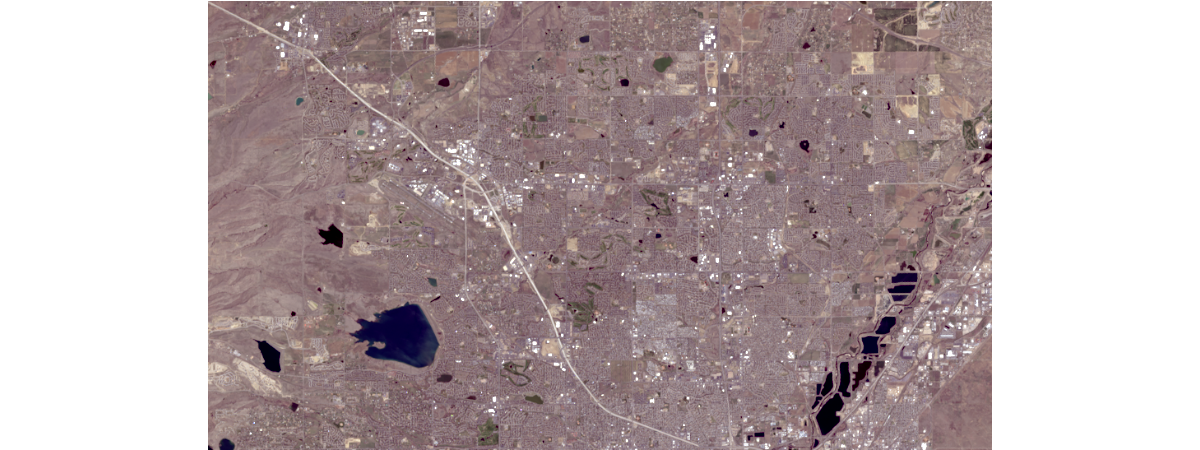

In [7]:
ras1 = raster.Raster(path = landsat_item.layers[0].url, gis=gis)
ras1

In [8]:
ras1.band_count

8

Preview imagery layer on a map

MapView(layout=Layout(height='400px', width='100%'))


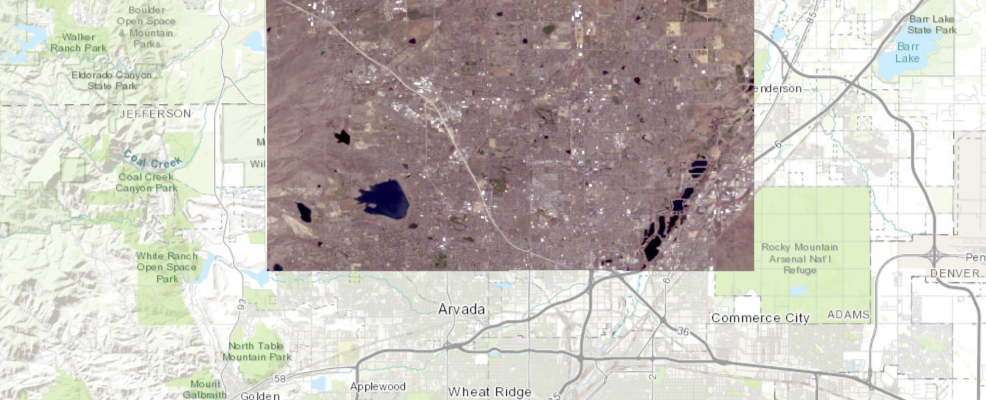

In [9]:
map1 = gis.map('Westminster, CO')
map1

In [10]:
map1.add_layer(ras1)

In [11]:
map1.take_screenshot(False, True)

## Train ISO classifier

In [12]:
iso_classifier_parameters = {'maxNumClasses':10, "max_iterations":25, 
                             "minNumSamples":100}

In [16]:
%%time
iso_ecs = raster.analytics.train_classifier(input_raster = ras1, 
                                            input_training_sample_json=None, 
                                           classifier_parameters = {'method':'iso',
                                                                   'params':iso_classifier_parameters},
                                           gis=gis)

CPU times: user 552 ms, sys: 45.6 ms, total: 597 ms
Wall time: 1min 14s


In [17]:
type(iso_ecs)

dict

In [18]:
iso_ecs.keys()

dict_keys(['EsriClassifierDefinitionFile', 'FileVersion', 'NumberDefinitions', 'Definitions'])

In [19]:
iso_ecs['FileVersion'], iso_ecs['NumberDefinitions'], len(iso_ecs['Definitions'])

(3, 1, 1)

In [20]:
iso_ecs['Definitions'][0].keys()

dict_keys(['Classifier', 'NumberClasses', 'RasterIsSegmented', 'NumberBands', 'Classes', 'Mins', 'Maxs', 'Raster1', 'IsoParams_MaxNumClasses', 'IsoParams_MaxNumIterations', 'IsoParams_MaxNumMergesPerIteration', 'IsoParams_MaxMergeDistance', 'IsoParams_MinNumPointsPerCluster', 'IsoParams_SkipFactor', 'MLC_Stats'])

In [21]:
iso_ecs['Definitions'][0]['NumberClasses']

8

### Write to disk for future

In [22]:
with open('./iso_ecs.json', 'w') as file_handle:
    json.dump(iso_ecs, file_handle)

Read from disk

In [13]:
with open('./iso_ecs.json', 'r') as file_handle:
    iso_ecs = json.load(file_handle)

### Analyze training metrics

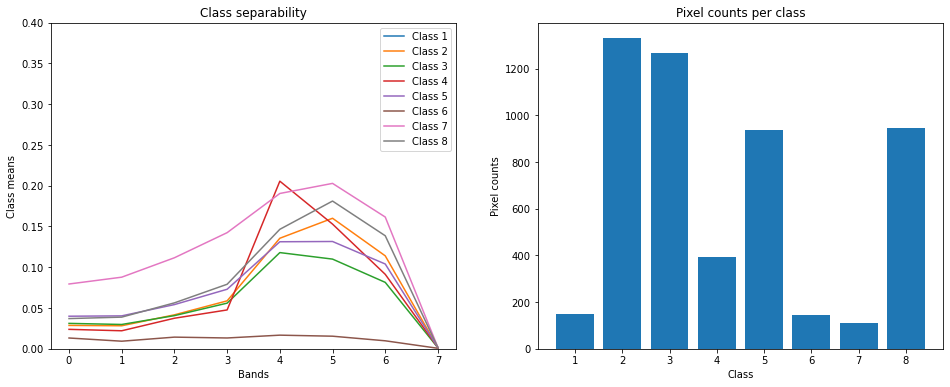

In [15]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
for index, e in enumerate(iso_ecs['Definitions'][0]['MLC_Stats']):
    ax[0].plot(e['Means'], label="Class "+str(index+1))
ax[0].legend(loc=0)
ax[0].set_ylim(0,0.4)
ax[0].set_xlabel('Bands')
ax[0].set_ylabel('Class means')
ax[0].set_title('Class separability');

class_counts = [i['Count'] for i in iso_ecs['Definitions'][0]['MLC_Stats']]
ax[1].bar(range(1,9),class_counts);
ax[1].set_title('Pixel counts per class')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Pixel counts');

## Classify raster

In [16]:
# timestamp
timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
print(timestamp)

20200930T152416


In [26]:
%%time
classified_raster = raster.analytics.classify(input_raster=ras1, 
                                              input_classifier_definition=iso_ecs,
                                              output_name = 'iso_classified_img_' + timestamp,
                                              gis = gis)

CPU times: user 116 ms, sys: 9.38 ms, total: 126 ms
Wall time: 19.2 s


In [29]:
print(classified_raster)

<Item title:"iso_classified_img_20200918T103700" type:Imagery Layer owner:portaladmin>


In [9]:
classified_raster = gis.content.search("iso_classified_img_20200918T103700")[0]

### Visualize classification result

In [19]:
# create a new map widget for viewing classified output
map2 = gis.map('Westminster, CO')
map2.add_layer(classified_raster)

# set hbox layout preferences
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

# create 2 hbox - one for title, another for maps
hb1 = HBox([Label('Landsat image'),Label('ISO classified raster')])
hb2 = HBox([map1, map2])
hb1.layout,hb2.layout = hbox_layout, hbox_layout

# synchronize both maps
map2.sync_navigation(map1)

# each hbox is a row in the vbox
VBox([hb1,hb2])

<img src=" 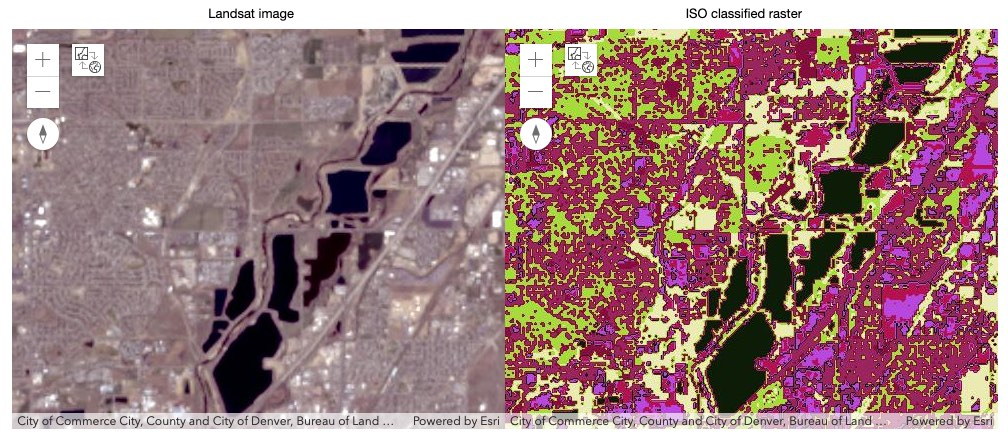">

## Post process classified output layer

In [10]:
classified_il = classified_raster.layers[0]

In [11]:
classified_il.attribute_table().keys()

dict_keys(['objectIdFieldName', 'fields', 'features'])

In [12]:
pd.DataFrame.from_records([f['attributes'] for f in classified_il.attribute_table()['features']])

,OID,Value,Classvalue,Class_name,Red,Green,Blue
0,0,0,0,0,241,241,187
1,1,1,1,1,233,235,179
2,2,2,2,2,166,219,60
3,3,3,3,3,135,12,62
4,4,4,4,4,153,36,94
5,5,5,5,5,13,28,6
6,6,6,6,6,183,71,222
7,7,7,7,7,179,18,77


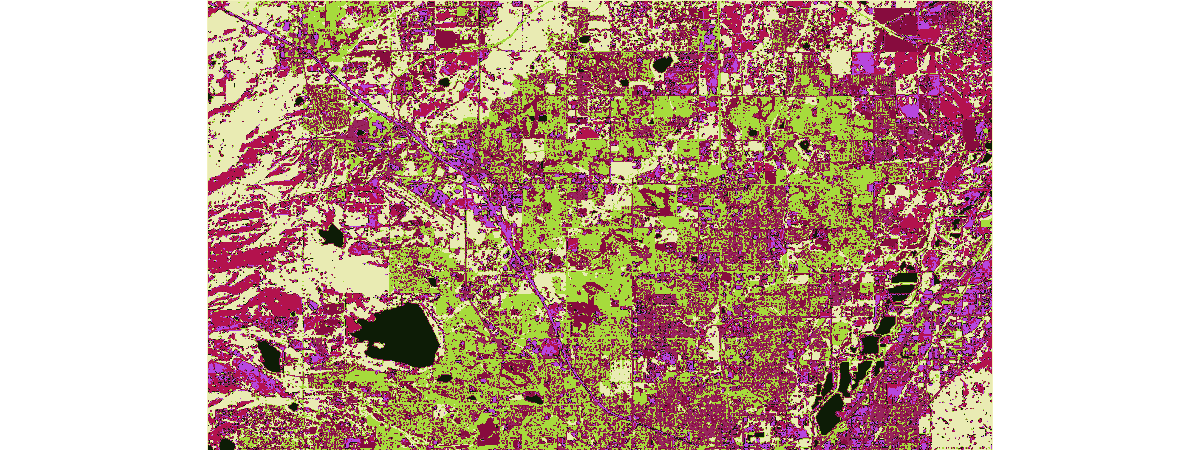

In [13]:
classified_ras = raster.Raster(classified_raster.layers[0].url, gis=gis)
classified_ras

In [28]:
classified_il = classified_raster.layers[0]

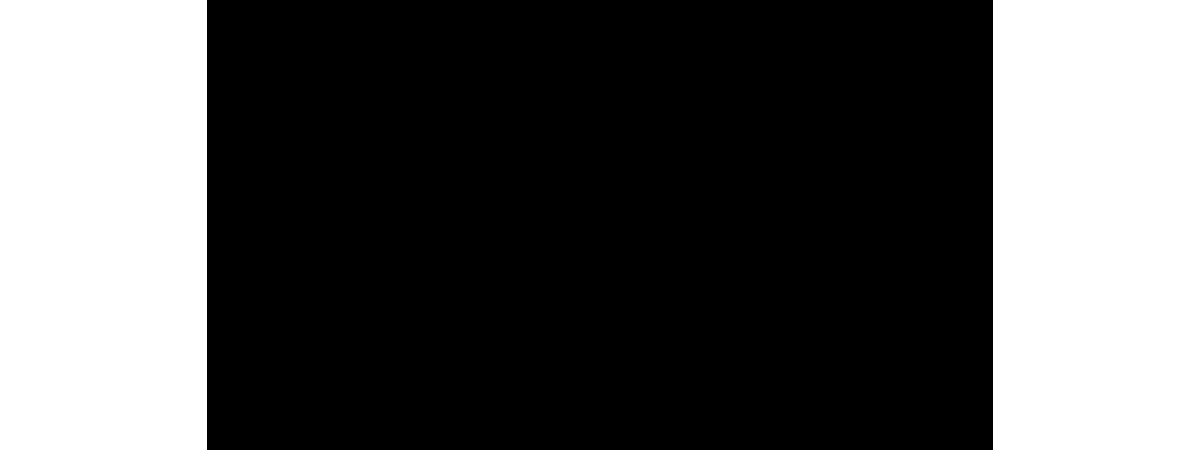

In [37]:
majority_ras = raster.functions.majority([classified_ras])
majority_ras

In [22]:
majority_ras.get_statistics()

[{'min': 0,
  'max': 7,
  'mean': 3.1854073145285295,
  'standardDeviation': 2.1037974194932536,
  'median': 2,
  'mode': 1,
  'skipX': 1,
  'skipY': 1,
  'count': 522385}]